In [17]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot as plt

import numpy as np
import random
import scipy as scp
import cv2 as cv

from keras.models import Model
from keras.layers import Dense,Input,Dropout
from keras.layers import Conv2D,Flatten,Reshape,MaxPool2D,MaxPooling2D,Conv2DTranspose,Activation
 
from sklearn.metrics import accuracy_score

# Image Retrieval CIFAR10, content based Image2Image semi-Supervised Learning

Text(0.5, 1.0, 'Model')

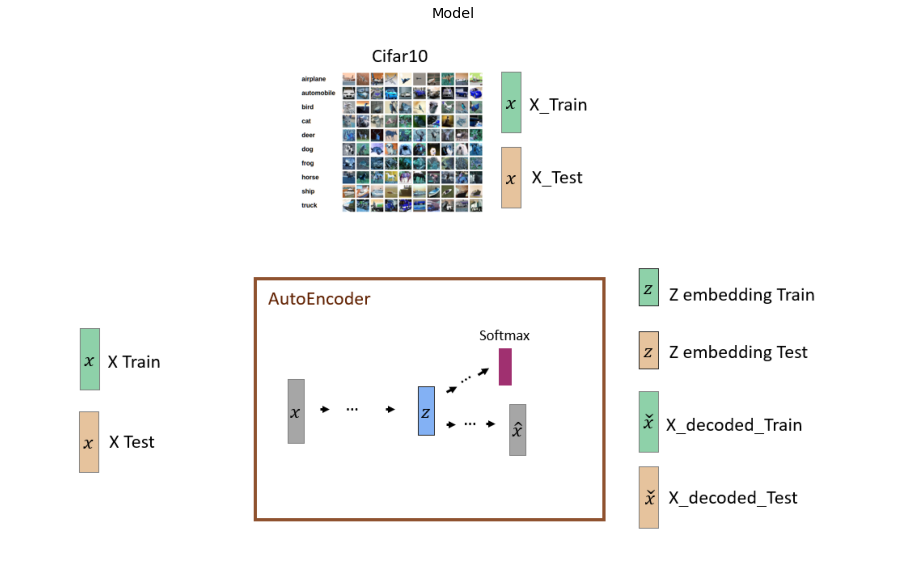

In [24]:
fig=plt.figure(figsize=(16, 16))

img = cv.imread("Imagen1.png")

ax = fig.add_subplot(1, 1, 1)
ax.grid(False)
ax.axis('off')
imgplot = plt.imshow(img)
ax.set_title('Model')

Text(0.5, 1.0, 'Solution')

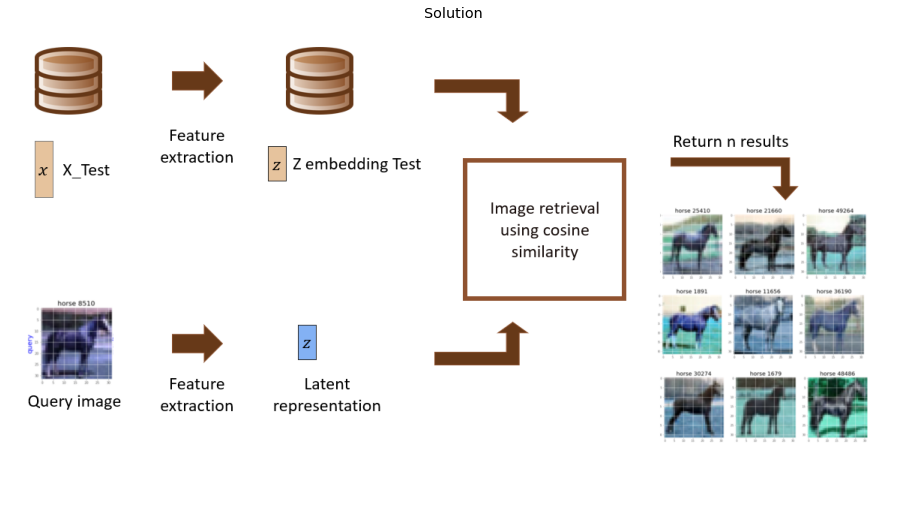

In [25]:
fig=plt.figure(figsize=(16, 16))

img = cv.imread("Imagen2.png")

ax = fig.add_subplot(1, 1, 1)
ax.grid(False)
ax.axis('off')
imgplot = plt.imshow(img)
ax.set_title('Solution')

## Load DataSet

In [2]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
# Normalized Data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1,32,32,3)
X_test = X_test.reshape(-1,32,32,3)

# One hot encoding representation
y_train_HE = keras.utils.to_categorical(y_train)
y_test_HE = keras.utils.to_categorical(y_test)

In [4]:
INPUT_SHAPE = (32,32,3)
DIM_ENCOD = 100
EPOCHS = 15
BATCH_SIZE = 128
NAMES = ['Airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
THRESHOLD = 10

## Artificial Neural Network Model

In [5]:
def Red(dim_encod,shape):
  input_img = Input(shape=shape)

  # Encoder Layers
  x = Conv2D(32, (3, 3), activation='relu', padding="same")(input_img)
  x = Conv2D(32, (3, 3), activation='relu', padding="same")(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Dropout(0.2)(x)
  x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
  x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  encoded = Dense(dim_encod, name="embedding")(x)


  # Decoder Layers
  flat_layer = Dense(4*4*128)(encoded)
  x = Reshape((4,4,128))(flat_layer)
  x = Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding="same")(x)
  x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding="same")(x)
  x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding="same")(x)
  decoded = Conv2DTranspose(3, (3, 3), padding="same", activation = 'sigmoid', name="decoded")(x)

  # Clasificación
  y = Dropout(0.5)(encoded)
  out_class = Dense(10, activation="softmax", name="out_class")(y)


  # Models
  autoencoder = Model(input_img, [decoded,out_class])
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='adam', loss=['mse','categorical_crossentropy'],metrics=["accuracy"])
  return autoencoder, encoder
AE_3, E_3 = Red(DIM_ENCOD,INPUT_SHAPE)

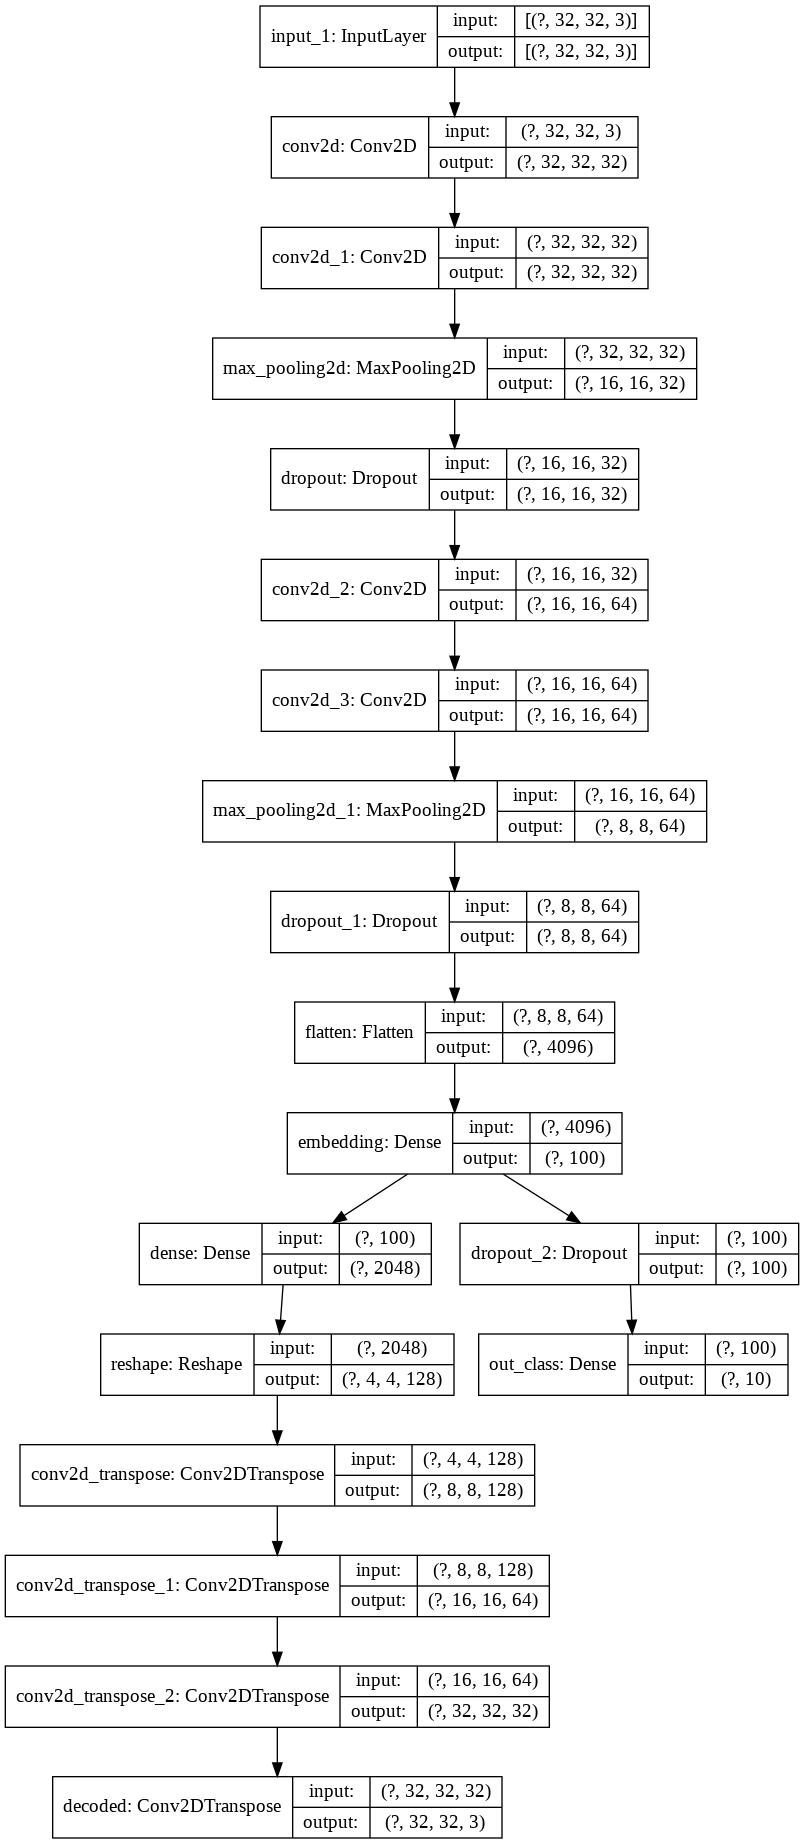

In [6]:
plot_model(AE_3, show_shapes=True, show_layer_names=True)

In [7]:
history_AE_3 = AE_3.fit(X_train, [X_train,y_train_HE], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/15
313/313 [==============================] - 7s 22ms/step - loss: 1.7243 - decoded_loss: 0.0411 - out_class_loss: 1.6831 - decoded_accuracy: 0.5664 - out_class_accuracy: 0.3844 - val_loss: 1.3175 - val_decoded_loss: 0.0277 - val_out_class_loss: 1.2897 - val_decoded_accuracy: 0.6237 - val_out_class_accuracy: 0.5326
Epoch 2/15
313/313 [==============================] - 6s 20ms/step - loss: 1.2718 - decoded_loss: 0.0306 - out_class_loss: 1.2412 - decoded_accuracy: 0.6051 - out_class_accuracy: 0.5572 - val_loss: 1.1052 - val_decoded_loss: 0.0260 - val_out_class_loss: 1.0792 - val_decoded_accuracy: 0.6025 - val_out_class_accuracy: 0.6181
Epoch 3/15
313/313 [==============================] - 6s 20ms/step - loss: 1.0802 - decoded_loss: 0.0286 - out_class_loss: 1.0516 - decoded_accuracy: 0.6012 - out_class_accuracy: 0.6281 - val_loss: 0.9396 - val_decoded_loss: 0.0261 - val_out_class_loss: 0.9135 - val_decoded_accuracy: 0.6159 - val_out_class_accuracy: 0.6760
Epoch 4/15
313/313 [=====

## Results

In [8]:
# Decoded images
X_decoded_train,_ = AE_3.predict(X_train)
X_decoded_test,_ = AE_3.predict(X_test)

# Latent representation
Z_embedding_train = E_3.predict(X_train)
Z_embedding_test = E_3.predict(X_test)

Text(0.5, 1.0, 'Decoded image')

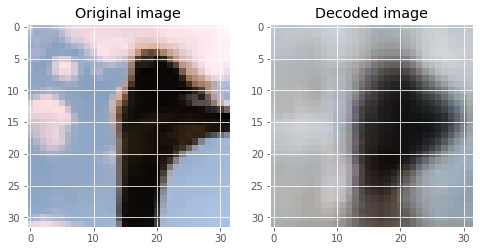

In [43]:
fig=plt.figure(figsize=(8, 8))

_img = random.randint(0,X_test.shape[0])

ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(X_test[_img])
ax.set_title('Original image')

ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(X_decoded_test[_img])
ax.set_title('Decoded image')

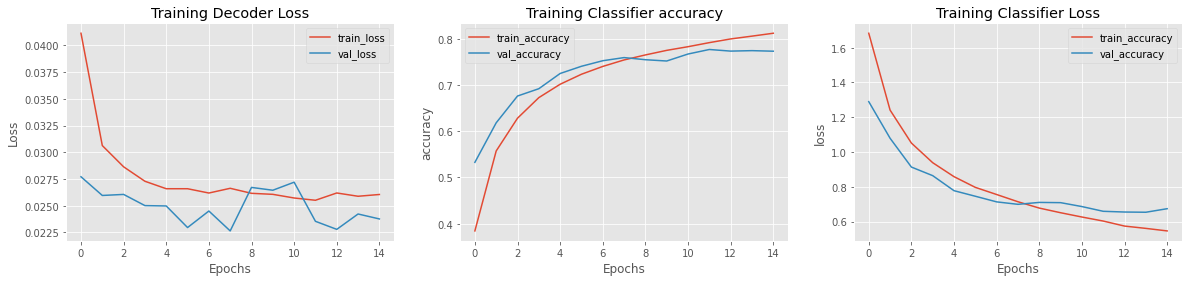

In [10]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(N, history_AE_3.history["decoded_loss"], label="train_loss")
plt.plot(N, history_AE_3.history["val_decoded_loss"], label="val_loss")
plt.title("Training Decoder Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

ax = fig.add_subplot(1, 3, 2)
plt.plot(N, history_AE_3.history["out_class_accuracy"], label="train_accuracy")
plt.plot(N, history_AE_3.history["val_out_class_accuracy"], label="val_accuracy")
plt.title("Training Classifier accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(loc="upper left")

ax = fig.add_subplot(1, 3, 3)
plt.plot(N, history_AE_3.history["out_class_loss"], label="train_accuracy")
plt.plot(N, history_AE_3.history["val_out_class_loss"], label="val_accuracy")
plt.title("Training Classifier Loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(loc="upper right")

## Image Search

In [11]:
DataBase = {"indexes": range(X_train.shape[0]), "features": Z_embedding_train}

In [12]:
def DBsearch(queryImg, DataBase, nResults= 10):
	results = []
	for i in range(len(DataBase["features"])):
		d = distance(queryImg, DataBase["features"][i])
		results.append((d, i))
	results = sorted(results)[:nResults]
	return results

def distance(a, b, CosineSimilarity = True):
	if(CosineSimilarity):
		# Cosine Similarity
		return scp.spatial.distance.cosine(a,b)
	else:
		# Euclidean Distance
		return np.linalg.norm(a - b)

In [13]:
N_QUERIES = 10
queries_imgs =  random.sample(range(Z_embedding_test.shape[0]), N_QUERIES)
result_queries = [ DBsearch(Z_embedding_test[i], DataBase, THRESHOLD) for i in queries_imgs]

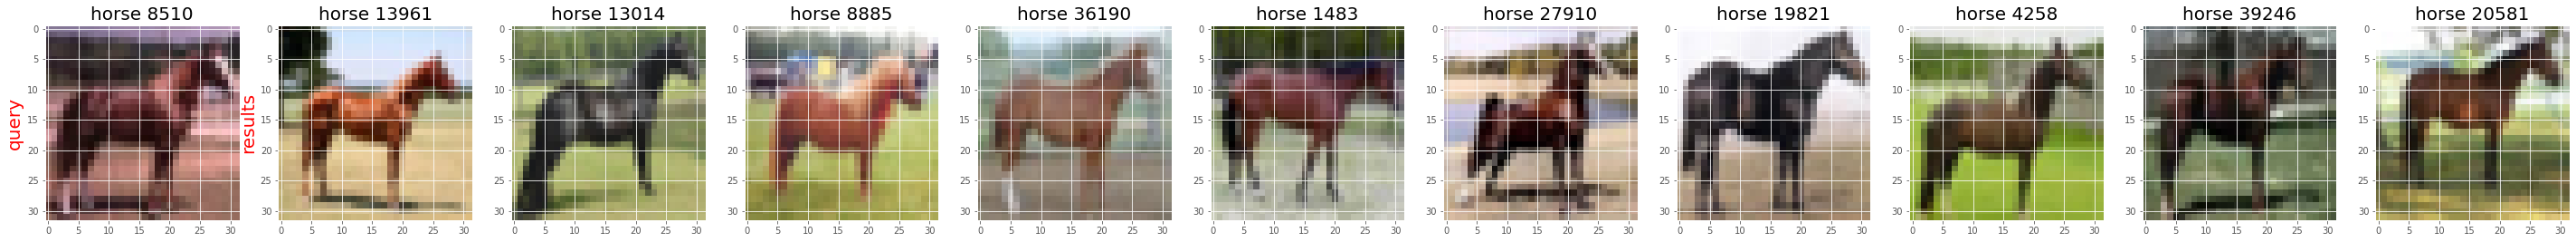

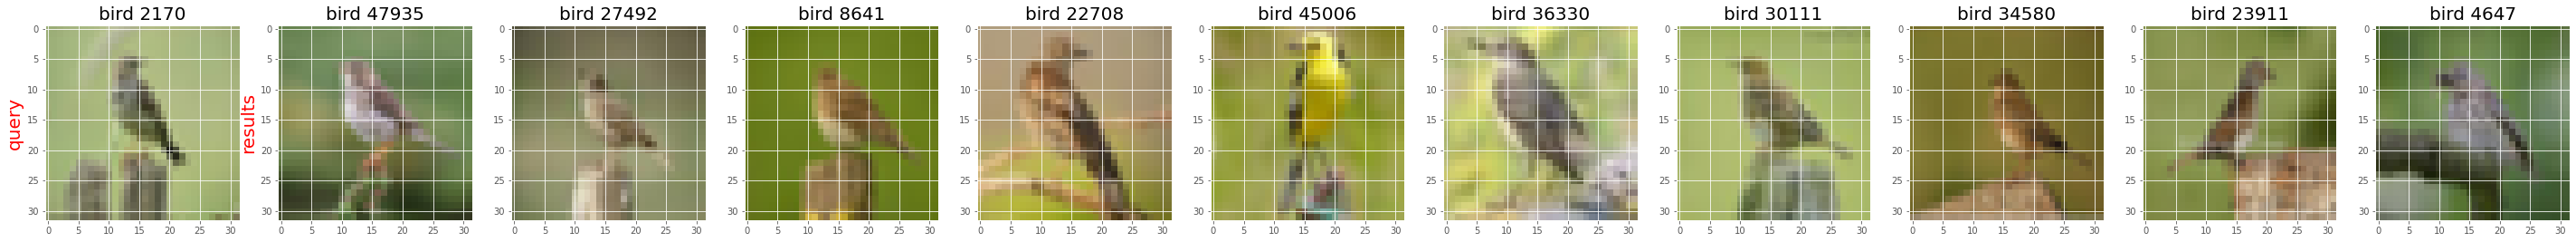

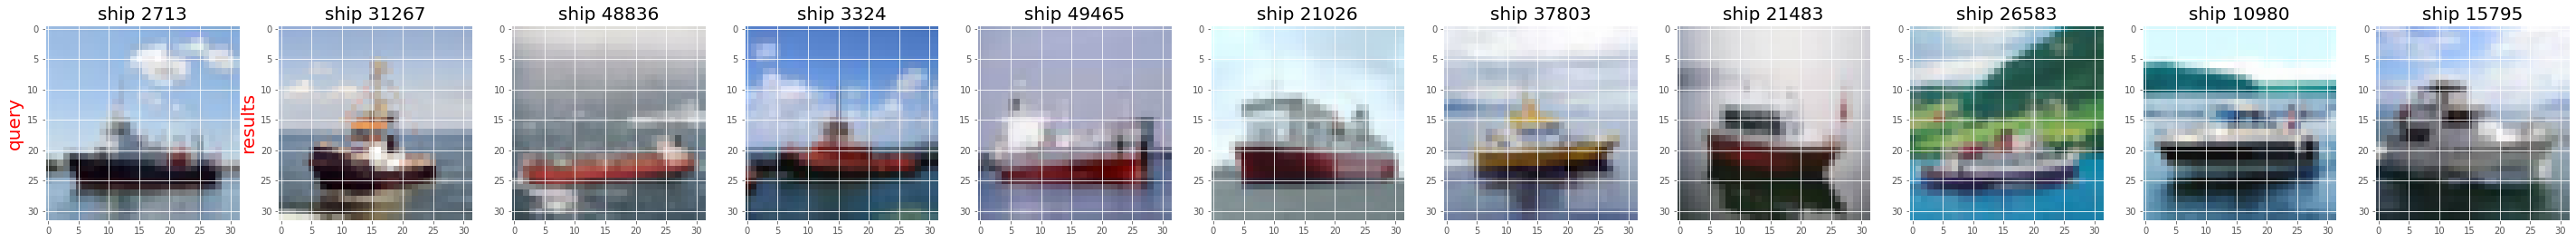

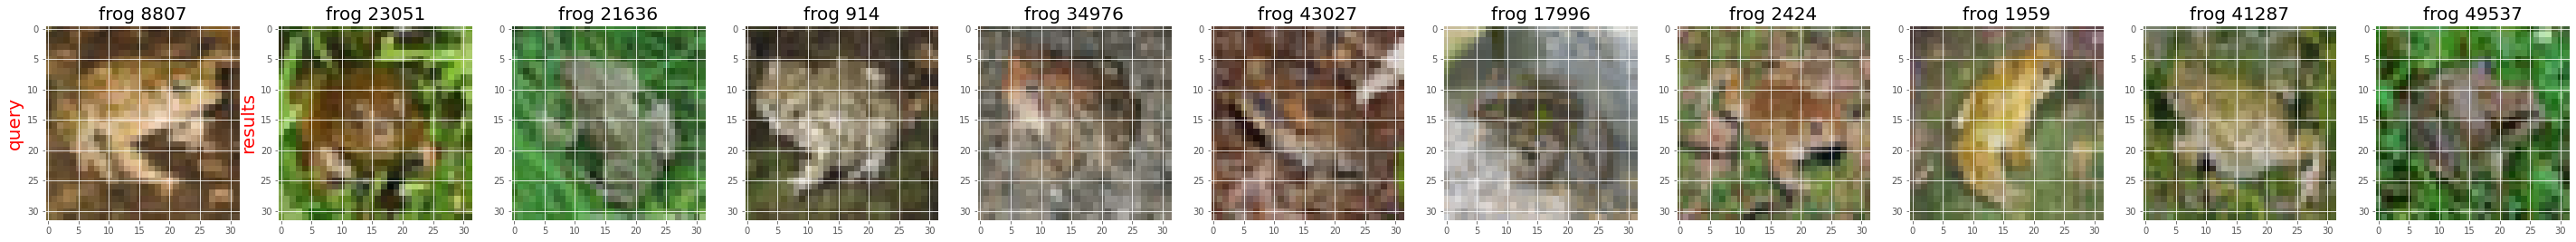

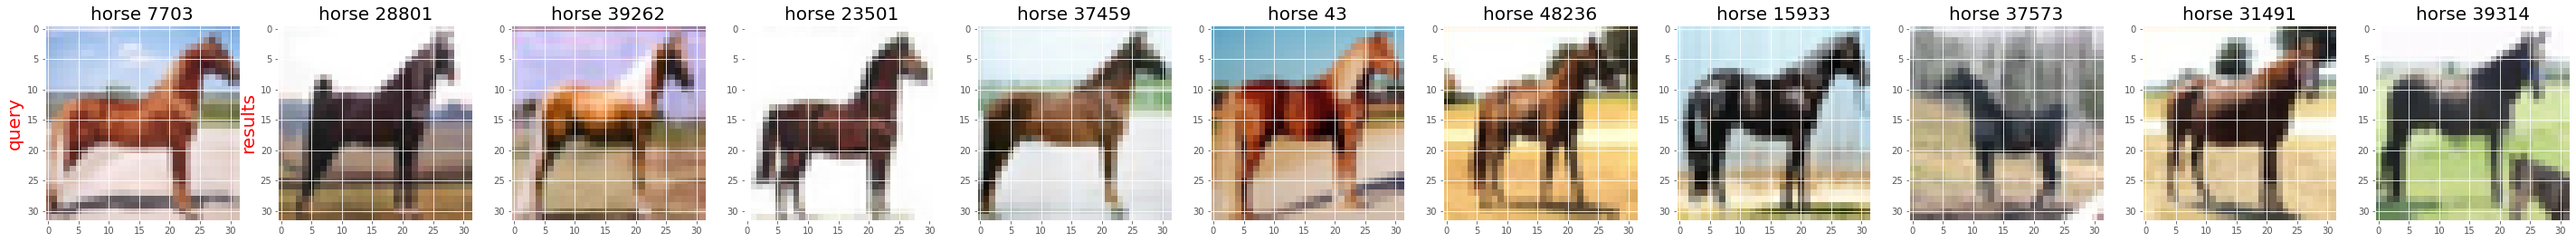

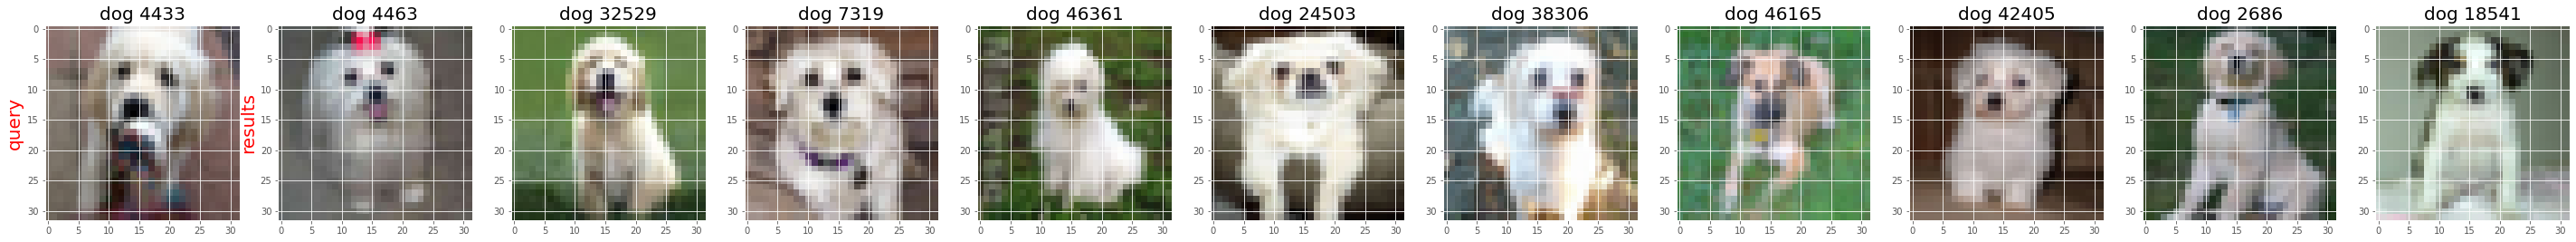

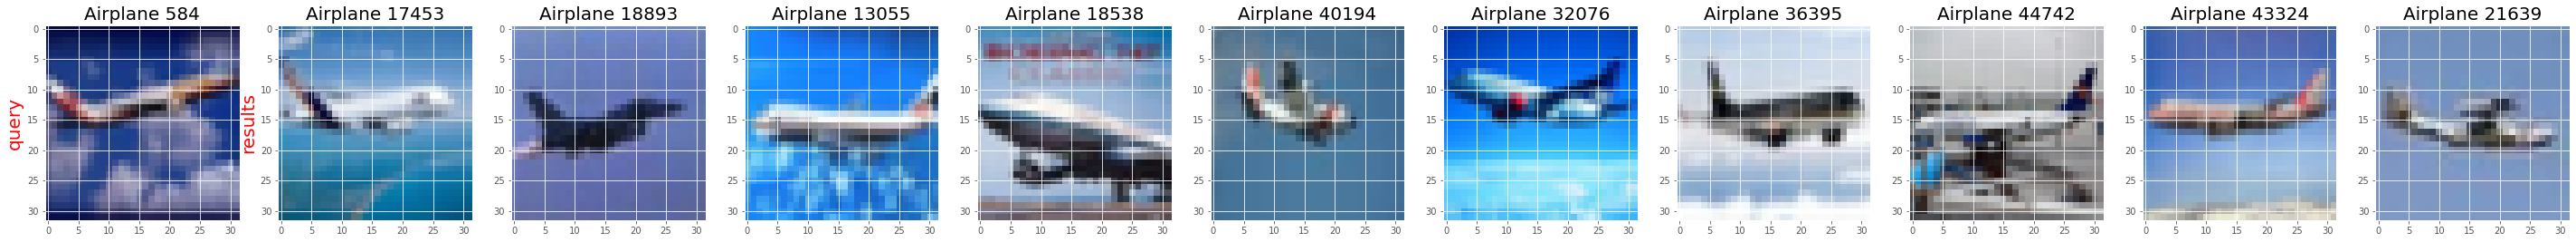

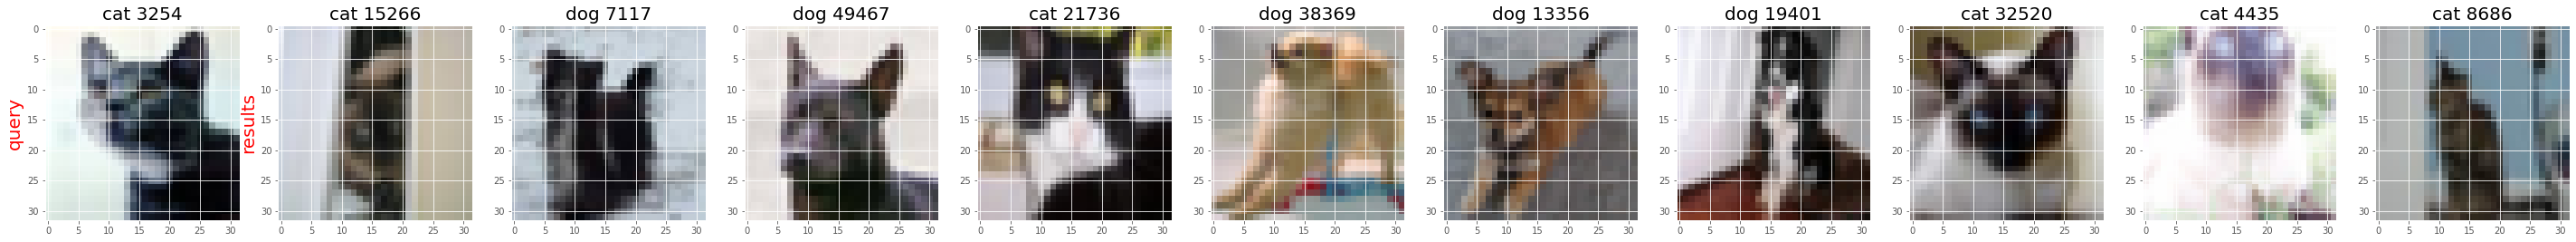

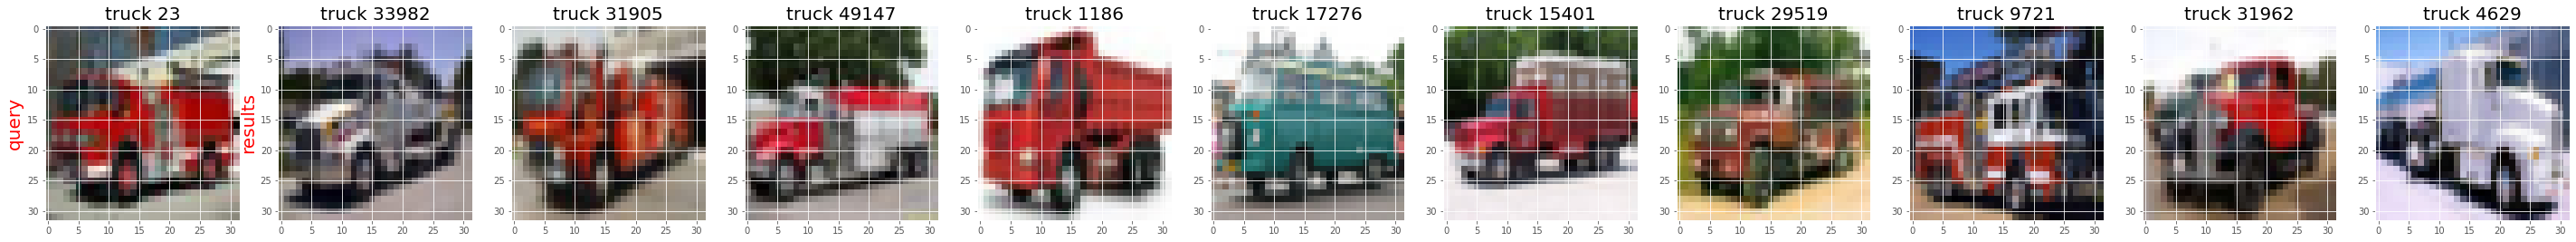

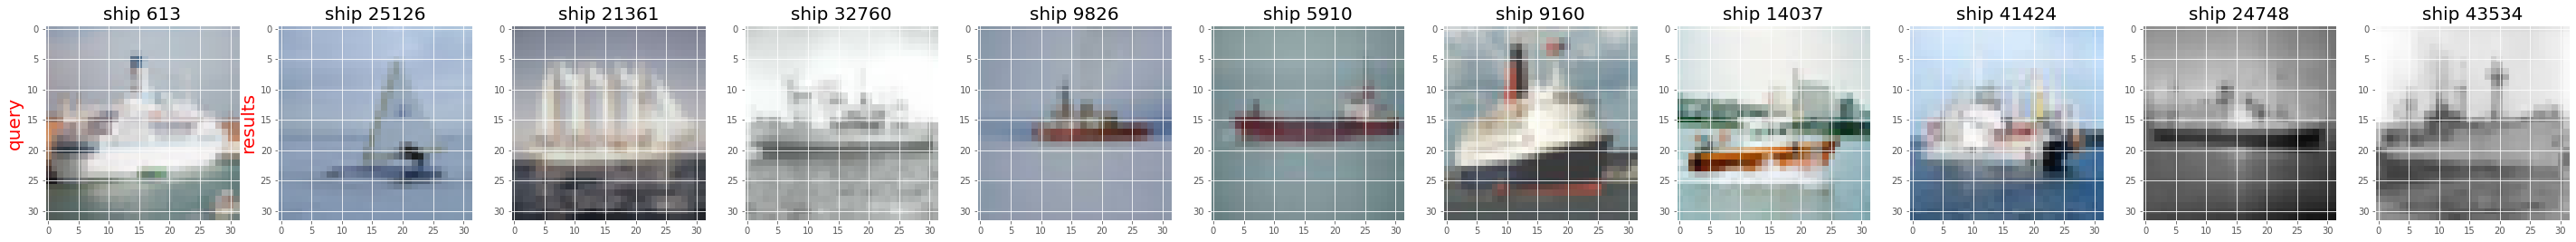

In [14]:
for i in range(N_QUERIES):
  res = result_queries[i]
  _img = queries_imgs[i]
  N = len(res)

  fig=plt.figure(figsize=(50, 32))
  ax = fig.add_subplot(1, N+1, 1)
  plt.imshow(X_test[_img])
  ax.set_ylabel('query',fontsize=20, color='r')
  plt.title(f'{NAMES[y_test[_img][0]]} {_img}',fontsize=20)
  for i in range(N):
    _index = res[i][1]
    ax = fig.add_subplot(1, N+1, i+2)
    imgplot = plt.imshow(X_train[_index])
    ax.set_title(f'{NAMES[y_train[_index][0]]} {_index}',fontsize=20)
    if(i==0):
      ax.set_ylabel('results',fontsize=20, color='r')